# **VGG16 using Melspctrogram and MFCC**
In this trial we decided to use the pretrained network VGG16 with a binary classifier on top. The results showed are computed with MFCC transormation To get the other results decomment the read_as_melspectrogram function, comment the read_as_mfccs one and choose the right input size.

In [ ]:
import numpy as np 
import pandas as pd
import os
import librosa
import matplotlib.pyplot as plt
import gc
import time
from tqdm import tqdm, tqdm_notebook; tqdm.pandas() # Progress bar
from sklearn.metrics import label_ranking_average_precision_score
from sklearn.model_selection import train_test_split
from scipy.io import wavfile

import tensorflow as tf
import keras
from keras import backend as K
from tensorflow.keras.layers import Layer, InputSpec
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.layers import (Dense, Bidirectional, LSTM, ELU,
                          Dropout, LeakyReLU, Conv1D, BatchNormalization)
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from tensorflow.keras.applications import VGG16
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


seed = 1235
np.random.seed(seed)

---
We define two function to calculate the Melspectrogram and the MFCCs for the further processing. In this case the spectrograms are converted in RGB because the VGG16 want 3 channels inputs.

In [ ]:
def read_as_melspectrogram(path):
    '''
    Convert audio into a melspectrogram 
    so we can use machine learning
    '''
    y,sr = librosa.load(path, sr=44100)
    
    spect = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=1024)

    spect = librosa.power_to_db(spect)

    spect = tf.expand_dims(spect, axis=-1)
    return tf.image.grayscale_to_rgb(spect)

def read_as_mfccs(path):
    '''
    Convert audio into a mfcc 
    so we can use machine learning
    '''
    y, sr = librosa.load(path, sr=44100)
    
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_fft=2048, hop_length=1024)
    spect = librosa.power_to_db(mfccs)
    spect = tf.expand_dims(spect, axis=-1)
    
    # Add zero padding to match the required input shape
    desired_shape = (32, 345, 1)
    padded_spect = np.pad(spect, [(0, desired_shape[0] - spect.shape[0]), (0, 0), (0, 0)], mode='constant')
    
    padded_spect = tf.convert_to_tensor(padded_spect)
    return tf.image.grayscale_to_rgb(padded_spect)




def convert_wav_to_image(df): 
    X = []
    for _,row in tqdm(df.iterrows()):
        x = read_as_mfccs(row.path)
        #x = read_as_melspectrogram(row.path) 
        X.append(x)
    return X

---
Open the csv and create the train, validation and test sets

In [ ]:
df = pd.read_csv("splitted_total.csv")
path = df["path"].values
labels = df["label"].values

# Preprocess dataset and create validation sets
X1 = np.array(convert_wav_to_image(df))


train_paths, test_paths, train_labels, test_labels = train_test_split(X1, labels, test_size=0.2, random_state=123)
train_paths, val_paths, train_labels, val_labels = train_test_split(train_paths, train_labels, test_size=0.15, random_state=123)

2001it [18:17,  1.82it/s]


---
Here we import the VGG16 model and create the network.

In [ ]:
conv_base = tf.keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(32, 345, 3)
    #input_shape=(128, 345, 3)
    )
conv_base.trainable = False
inputs = keras.Input((32, 345, 3))
x = conv_base(inputs)
x = layers.Flatten()(x)
x = layers.Dense(128)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
#learning_rate = 0.00001
learning_rate = 0.00003
optimizer = optimizers.Adam(learning_rate=learning_rate)
model.compile(loss="binary_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

model.summary()
early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min', verbose=1)

58889256/58889256 [==============================] - 9s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 345, 3)]      0         
                                                                 
 vgg16 (Functional)          (None, 1, 10, 512)        14714688  
                                                                 
 flatten (Flatten)           (None, 5120)              0         
                                                                 
 dense (Dense)               (None, 128)               655488    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                              

---
We define the batch size and the number of epochs. Then, we fit the model.

In [ ]:
batch_size=80
epochs = 45
history = model.fit(train_paths, train_labels, epochs=epochs, batch_size = batch_size,
                    validation_data=(val_paths, val_labels), shuffle=False, callbacks=[early_stopping])

Epoch 1/45
17/17 [==============================] - 84s 5s/step - loss: 2.8583 - accuracy: 0.5044 - val_loss: 0.8268 - val_accuracy: 0.6708
Epoch 2/45
17/17 [==============================] - 100s 6s/step - loss: 1.5320 - accuracy: 0.6507 - val_loss: 0.6540 - val_accuracy: 0.8167
Epoch 3/45
17/17 [==============================] - 102s 6s/step - loss: 0.9844 - accuracy: 0.7574 - val_loss: 0.6606 - val_accuracy: 0.8500
Epoch 4/45
17/17 [==============================] - 109s 7s/step - loss: 0.7303 - accuracy: 0.8110 - val_loss: 0.5680 - val_accuracy: 0.8542
Epoch 5/45
17/17 [==============================] - 123s 7s/step - loss: 0.8038 - accuracy: 0.8118 - val_loss: 0.5166 - val_accuracy: 0.8875
Epoch 6/45
17/17 [==============================] - 144s 9s/step - loss: 0.6661 - accuracy: 0.8353 - val_loss: 0.4911 - val_accuracy: 0.8917
Epoch 7/45
17/17 [==============================] - 199s 12s/step - loss: 0.5330 - accuracy: 0.8610 - val_loss: 0.4703 - val_accuracy: 0.9042
Epoch 8/45
17

---
Plotting the loss function and the accuracy for both train and validation set. 

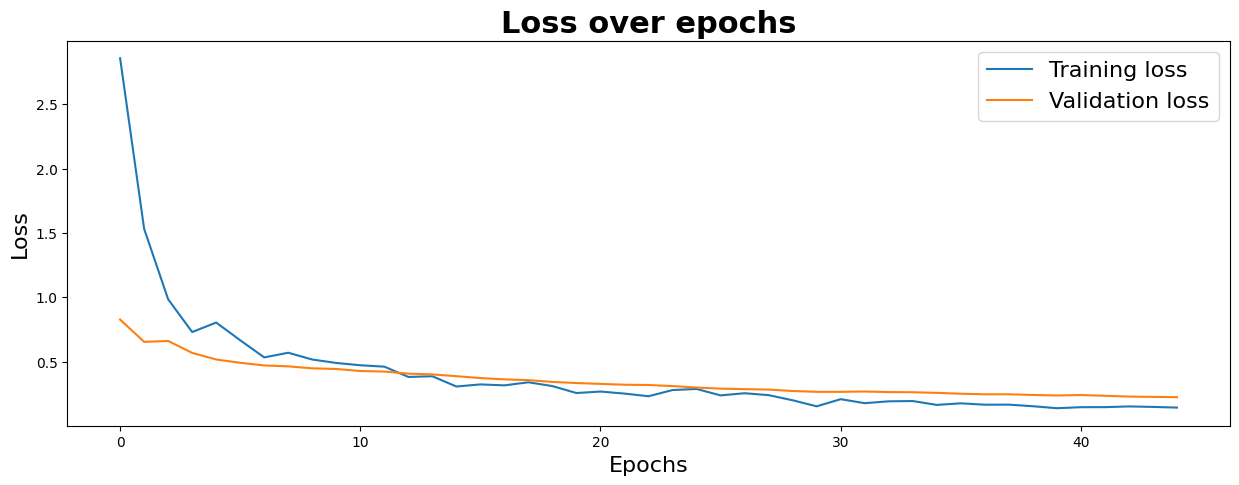

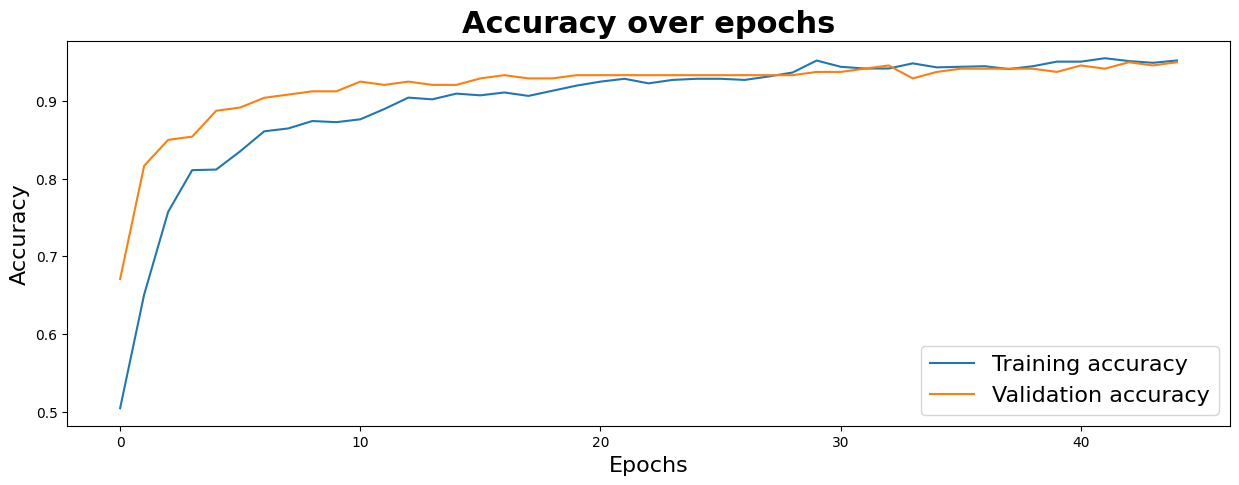

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_executed = early_stopping.stopped_epoch + 1
if epochs_executed != 1:
    rg = epochs_executed
else:
    rg = epochs    
plt.figure(figsize=(15,5))
plt.plot(range(rg), loss)
plt.plot(range(rg), val_loss)
plt.title('Loss over epochs', weight='bold', fontsize=22)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(['Training loss', 'Validation loss'], fontsize=16)
plt.show()


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.figure(figsize=(15,5))
plt.plot(range(rg), acc)
plt.plot(range(rg), val_acc)
plt.title('Accuracy over epochs', weight='bold', fontsize=22)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend(['Training accuracy', 'Validation accuracy'], fontsize=16)
plt.show()

Evaluating the model on the test set, calculating the confusion matrix, the f1-score, the recall and the accuracy

13/13 [==============================] - 30s 2s/step


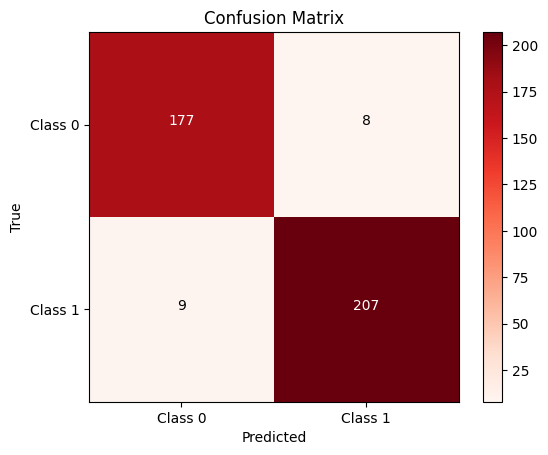

              precision    recall  f1-score   support

           0       0.95      0.96      0.95       185
           1       0.96      0.96      0.96       216

    accuracy                           0.96       401
   macro avg       0.96      0.96      0.96       401
weighted avg       0.96      0.96      0.96       401



In [ ]:
test_loss, test_accuracy = model.evaluate(test_paths, test_labels)

predictions = model.predict(test_paths)

# Convert the predicted probabilities to class labels (0 or 1 in this case)
y_pred = (predictions > 0.5).astype(int)

# Compute the confusion matrix
cm = confusion_matrix(test_labels, y_pred)

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Reds)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Class 0', 'Class 1'])
plt.yticks(tick_marks, ['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('True')
# Add text annotations within each cell
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.show()

#Printing the accuracy, the f1-score and the recall for each class
predicted_probabilities = predictions.flatten()
predicted_labels = (predicted_probabilities >= 0.5).astype(int)

report = classification_report(test_labels, predicted_labels)
print(report)

In [ ]:
model.save("Notebook\VGG16")

INFO:tensorflow:Assets written to: Notebook\VGG16\assets


INFO:tensorflow:Assets written to: Notebook\VGG16\assets
